We are an agency helping our customers purchase XoX (a made-up product) from various makers. Price is one of the most important things we care about. We need to estimate the price of a XoX before we recommend it to our customers. However, the estimations vary significantly with our employees' experience. 

We would like you to build a machine learning model to accurately predict the price for a future purchase and provide insights to help us explain the predicted price to our customers. Please note that neither our customers nor us have any knowledge about machine learning. A sample of our sales record is available in ../data/sales.csv.


1. Preprocess, clean, analyze and visualized the provided data. A few sentences or plots describing your approach will suffice. Any thing you would like us to know about the price?
2. Build a machine learning model to help us determine the price for a purchase. Discuss why you choose the approaches, what alternatives you consider, and any concerns you have. How is the performance of your model?
3. Help us understand how the price is predicted (again, a few sentences will suffice).

## 1 Preprocess, Clean, Analyze, and Visualized the Data

In [1]:
import pandas as pd
df = pd.read_csv('../data/sales.csv')
df.dropna(subset=['price'], inplace=True)
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


Text(0, 0.5, 'NA Count')

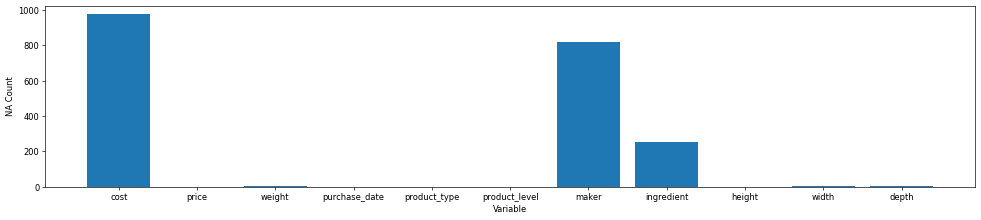

In [2]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pyplot import figure

figure(figsize=(20, 4), dpi=60)

plt.bar(df.columns,df.isnull().sum())
plt.xlabel('Variable')
plt.ylabel('NA Count')

### (A) Cleaning

#### (i) Numeric Cleaning/Transformation

In [3]:
class Numeric_Transformer:
    
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        df['cost'] = X.cost.map(self.col2Numeric)*1000
        df['weight'] = X.weight.map(self.wght2Numeric)
        df['height'] = X.height.map(self.col2Numeric)*100
        df['width'] = X.width.map(self.col2Numeric)
        df['depth'] = X.depth.map(self.col2Numeric)
        df["Month"] = pd.to_datetime(X.purchase_date).dt.month
        df["Year"] = pd.to_datetime(X.purchase_date).dt.year
        df["type_count"] = df['product_type'].str.count(',')+1
        df["ingrd_count"] = df['ingredient'].str.count(',')+1
        df = df.drop(columns=['purchase_date'])
        return df

    def fit_transform(self, X, y=None):
        self.fit(X)
        X = self.transform(X)
        return X  
    
    def col2Numeric(self,val):
        if type(val) == str:
            val = val.strip("$").replace(",","").strip("cm").strip("meters").strip("k")
        return float(val)

    #convert weight to kg
    def wght2Numeric(self,val):
        if type(val) == str:
            val = val.strip(" Kg")
            val = val.split(" Ton")
            val = (float(val[0])*1000)+ float(val[1])
        return val

#### (ii) Categorical Cleaning/Transformation

In [4]:
def single_valuecounts(column):
    return column.str.split(',').explode().value_counts()

print(single_valuecounts(df.maker).head()) #length = 888 unique  (discard and keep counts only)
print(single_valuecounts(df.ingredient).head()) #length = 2035 unique (discard and keep counts only)
print(single_valuecounts(df.product_type)) #length = 23 unique (keep only counts >=90)
#["V","G","W","M","L","E","I","O"]

M14196    17
M14346    16
M14170    15
M14163    15
M14565    14
Name: maker, dtype: int64
IN732658    64
IN732094    51
IN732489    44
IN732074    42
IN732583    41
Name: ingredient, dtype: int64
D    1100
H     642
A     500
U     393
N     331
R     245
B     217
C     201
J     196
S     177
F     146
K     110
T      93
P      90
Q      90
V      38
G      22
W      19
M      17
L      16
E      11
I       6
O       2
Name: product_type, dtype: int64


In [5]:
from sklearn.preprocessing import LabelEncoder

class Categorical_Transformer:
    
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        le = LabelEncoder()
        df = pd.concat([X, X['product_type'].str.get_dummies(sep=',')], axis=1)
        df = df.drop(['maker','ingredient','product_type','V','G','W','M','L','E','I','O'],
                    axis = 1,errors='ignore')
        df[['product_level']]= le.fit_transform(df['product_level'])
        return df

    def fit_transform(self, X, y=None):
        self.fit(X)
        X = self.transform(X)
        return X  

#### (iv) Split

In [6]:
from sklearn.model_selection import train_test_split

features = list(df.columns)
target = 'price'
features.remove(target)

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=123)

def price2num(x):
    if type(x) == str: 
        x = x.strip('$').replace(',', '')
    return float(x)

y_train = y_train.map(price2num)
y_test = y_test.map(price2num)

### (B) Analyze

#### (i) Numeric

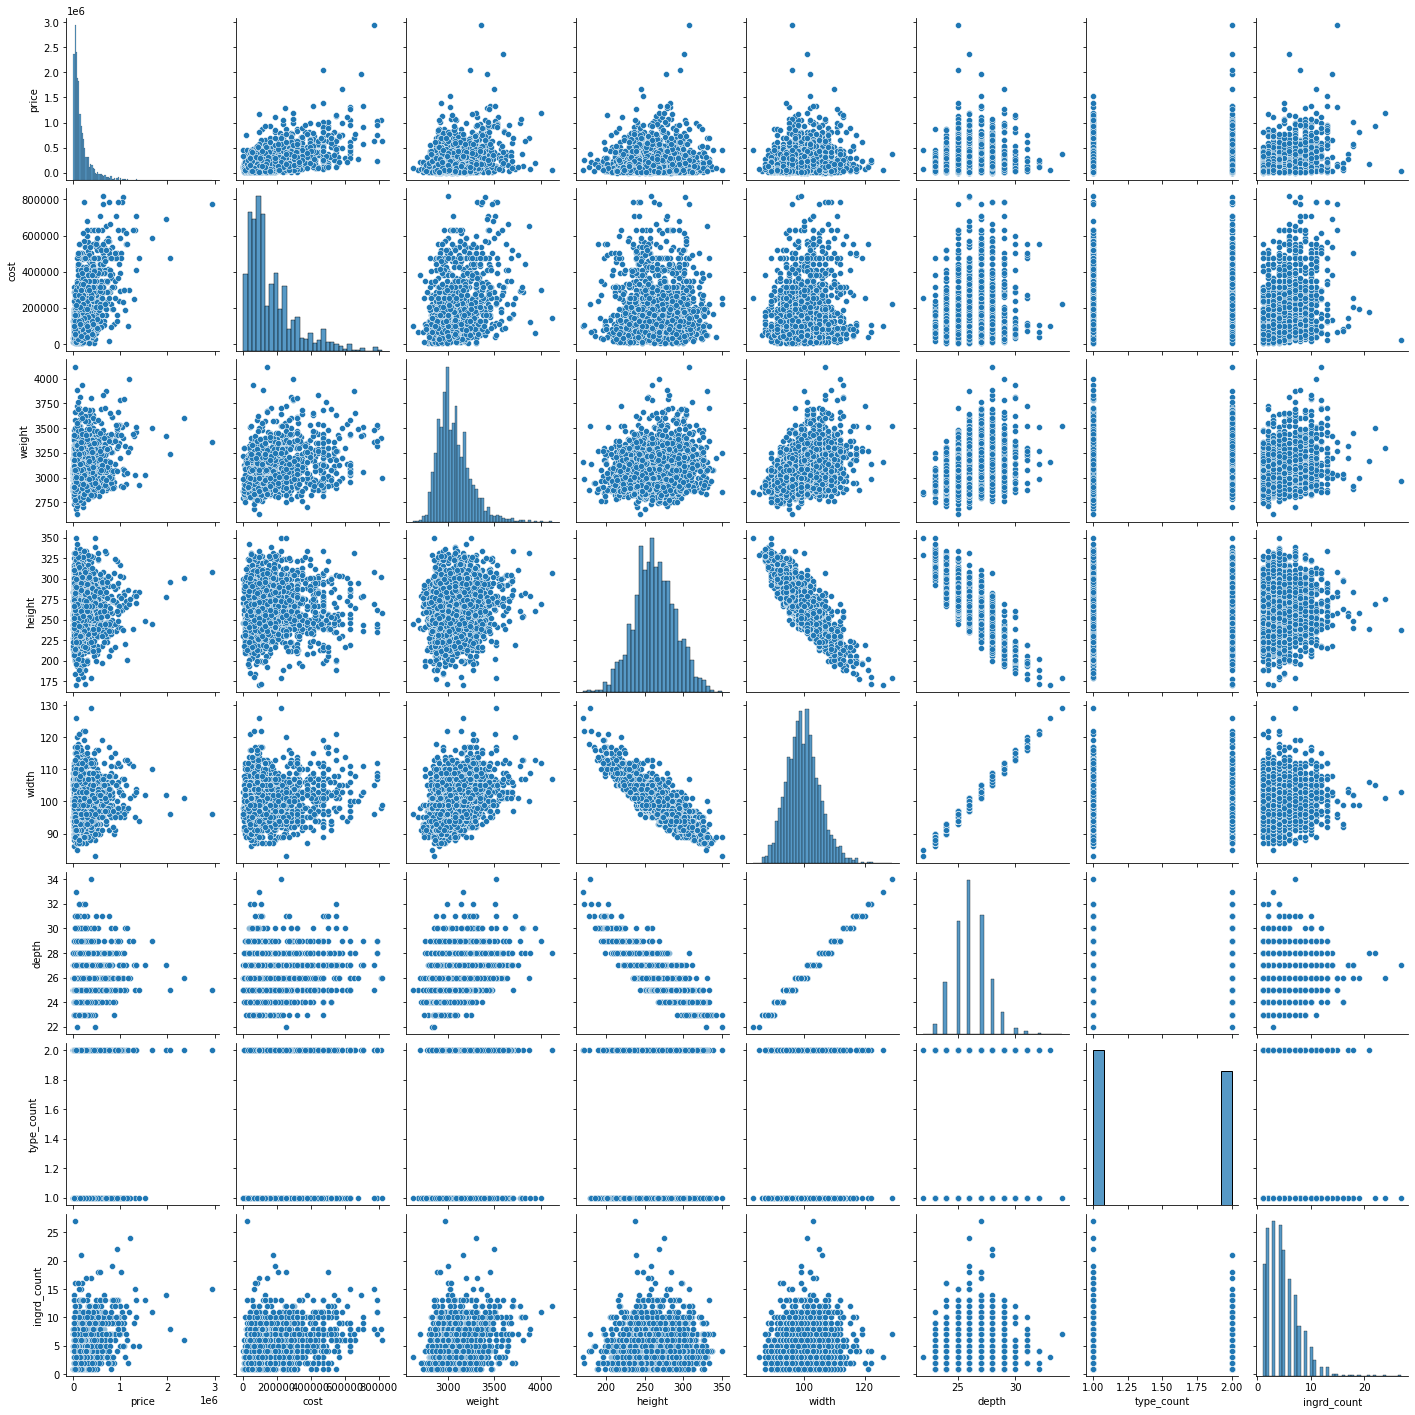

In [7]:
import seaborn as sns
from sklearn.pipeline import Pipeline 

steps = [('ntf', Numeric_Transformer()), 
         ('ctr', Categorical_Transformer())]

model = Pipeline(steps)
CleanedTrain = model.fit_transform(X_train,y_train)
CleanedTrain

sns.pairplot(pd.concat([y_train, CleanedTrain[['cost','weight','height','width','depth','type_count',
                                               'ingrd_count']]], axis=1))

<AxesSubplot:>

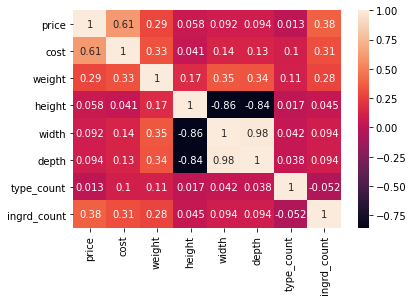

In [8]:
sns.heatmap(pd.concat([y_train, CleanedTrain[['cost','weight','height','width','depth','type_count',
                                               'ingrd_count']]], axis=1).corr(method='pearson'), annot=True)

#### (ii) Categorical

<AxesSubplot:xlabel='product_level', ylabel='price'>

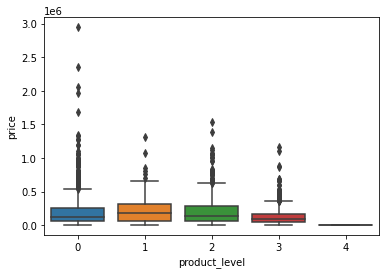

In [9]:
train=pd.concat([y_train,CleanedTrain], axis=1)
train2=train.rename(columns={0:"price"})
sns.boxplot(y="price", x="product_level", data=train2)

#### (iii) Date

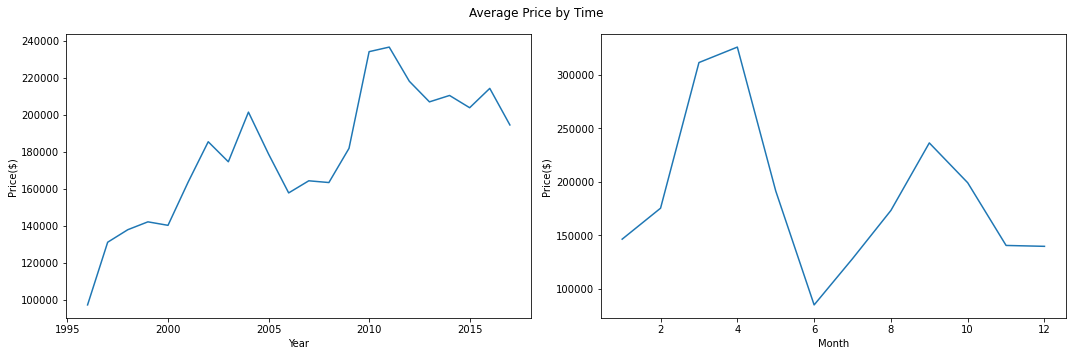

In [10]:
year = train2.groupby(['Year'],as_index=False).mean().Year
month = train2.groupby(['Month'],as_index=False).mean().Month
annualAve = train2.groupby(['Year'],as_index=False).mean().price
monAve = train2.groupby(['Month'],as_index=False).mean().price

figure, axis = plt.subplots(1, 2,figsize=(15,5))
figure.suptitle('Average Price by Time')
axis[0].plot(year,annualAve)
axis[0].set_ylabel('Price($)')
axis[0].set_xlabel('Year')


axis[1].plot(month, monAve)
axis[1].set_ylabel('Price($)')
axis[1].set_xlabel('Month')

figure.tight_layout() 
plt.show()

## 2 Build a Machine Learning Model

### (A) XGBoost

In [13]:
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

steps = [('ntf', Numeric_Transformer()), 
         ('ctr', Categorical_Transformer()),
         ('knn', KNNImputer(n_neighbors=5)),
         ('sc', StandardScaler()),
         ('xgbr', XGBRegressor(random_state=123))]

xgbmodel = Pipeline(steps)

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
scorer = make_scorer(mean_squared_error, greater_is_better = False)

params_new = {'xgbr__gamma': [0.0, 0.1, 0.2], 
              'xgbr__learning_rate': [0.1,0.3,0.5], 
              'xgbr__n_estimators': [100, 300, 500], 
              'xgbr__max_depth': [3, 5, 10]}

gs_results = GridSearchCV(estimator = xgbmodel, param_grid = params_new, cv = 5, scoring = scorer)
gs_results.fit(X_train,y_train)

gs_results.best_params_

{'xgbr__gamma': 0.0,
 'xgbr__learning_rate': 0.1,
 'xgbr__max_depth': 3,
 'xgbr__n_estimators': 100}

In [15]:
MSE_train = []

for n in range(1,26):
    
    steps = [('ntf', Numeric_Transformer()), 
         ('ctr', Categorical_Transformer()),
         ('knn', KNNImputer(n_neighbors=5)),
         ('sc', StandardScaler()),
         ('pca',PCA(n_components=n)),
         ('xgbr', XGBRegressor(gamma=0, 
                               learning_rate=0.1,
                               n_estimators=100,
                               max_depth=5))]

    model = Pipeline(steps)
    model = model.fit(X_train,y_train)
    
    MSE_train.append(mean_squared_error(y_train, model.predict(X_train))) 

Text(0.5, 0, 'n_components')

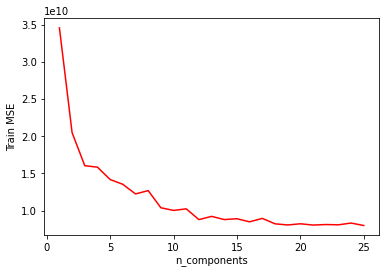

In [16]:
plt.plot(range(1,26), MSE_train, color='r')
plt.ylabel('Train MSE')
plt.xlabel('n_components') #n=12 looks good without seeming to overfit too much

In [23]:
steps = [('ntf', Numeric_Transformer()), 
         ('ctr', Categorical_Transformer()),
         ('knn', KNNImputer(n_neighbors=5)),
         ('sc', StandardScaler()),
         ('pca',PCA(n_components=12)),
         ('xgbr', XGBRegressor(gamma=0, 
                               learning_rate=0.1,
                               n_estimators=100,
                               max_depth=5))]

xgbmodel2 = Pipeline(steps)
xgbmodel2 = xgbmodel2.fit(X_train,y_train)

In [24]:
y_train_pred = xgbmodel2.predict(X_train)

print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 6.86e+04
train MSE: 8.79e+09
train R2: 0.815


In [25]:
y_test_pred = xgbmodel2.predict(X_test)

print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.11e+05
test MSE: 2.74e+10
test R2: 0.488


### (B) Linear Regression

In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

steps = [('ntf', Numeric_Transformer()), 
         ('ctr', Categorical_Transformer()),
         ('knn', KNNImputer(n_neighbors=5)),
         ('poly', PolynomialFeatures()),
         ('sc', StandardScaler()),
         ('lr', LinearRegression())]

lrmodel = Pipeline(steps)

In [27]:
params_new = {'poly__degree': range(1,5)}

gs_results = GridSearchCV(estimator = lrmodel, param_grid = params_new, cv = 5, scoring = scorer)
gs_results.fit(X_train,y_train)

gs_results.best_params_

{'poly__degree': 1}

In [28]:
MSE_train = []

for n in range(1,26):
    
    steps = [('ntf', Numeric_Transformer()), 
         ('ctr', Categorical_Transformer()),
         ('knn', KNNImputer(n_neighbors=5)),
         ('sc', StandardScaler()),
         ('pca',PCA(n_components=n, random_state=123)),
         ('lr', LinearRegression())]

    model = Pipeline(steps)
    model = model.fit(X_train,y_train)
    
    MSE_train.append(mean_squared_error(y_train, model.predict(X_train))) 

Text(0.5, 0, 'n_components')

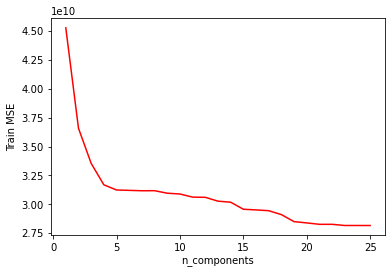

In [29]:
plt.plot(range(1,26), MSE_train, color='r')
plt.ylabel('Train MSE')
plt.xlabel('n_components') #n=19 looks okay?

In [36]:
steps = [('ntf', Numeric_Transformer()), 
         ('ctr', Categorical_Transformer()),
         ('knn', KNNImputer(n_neighbors=5)),
         ('sc', StandardScaler()),
         ('pca',PCA(n_components=19, random_state=123)),
         ('lr', LinearRegression())]

lrmodel2 = Pipeline(steps)
lrmodel2 = lrmodel2.fit(X_train,y_train)

In [37]:
y_train_pred = lrmodel2.predict(X_train)

print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 1.11e+05
train MSE: 2.85e+10
train R2: 0.399


In [38]:
y_test_pred = lrmodel2.predict(X_test)

print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.17e+05
test MSE: 3.02e+10
test R2: 0.435


### (C) Lasso

In [56]:
from sklearn.linear_model import Lasso
steps = [('ntf', Numeric_Transformer()), 
         ('ctr', Categorical_Transformer()),
         ('knn', KNNImputer(n_neighbors=5)),
         ('sc', StandardScaler()),
         ('lasso', Lasso(max_iter=100000))]

lassmodel = Pipeline(steps)

In [57]:
import warnings
warnings.filterwarnings("ignore")

params_new = {'lasso__alpha': [0,0.2,0.4,0.6,0.8]}

gs_results = GridSearchCV(estimator = lassmodel, param_grid = params_new, cv = 5, scoring = scorer)
gs_results.fit(X_train,y_train)

gs_results.best_params_

{'lasso__alpha': 0.8}

In [61]:
MSE_train = []

for n in range(1,26):
    steps = [('ntf', Numeric_Transformer()), 
             ('ctr', Categorical_Transformer()),
             ('knn', KNNImputer(n_neighbors=5)),
             ('sc', StandardScaler()),
             ('pca',PCA(n_components=n, random_state=123)),
             ('lasso', Lasso(max_iter=100000, alpha=0.8))]

    model = Pipeline(steps)
    model = model.fit(X_train,y_train)
    
    MSE_train.append(mean_squared_error(y_train, model.predict(X_train))) 

Text(0.5, 0, 'n_components')

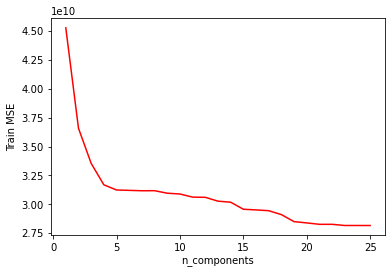

In [62]:
plt.plot(range(1,26), MSE_train, color='r')
plt.ylabel('Train MSE')
plt.xlabel('n_components') #n=19 looks good without seeming to overfit too much

In [63]:
steps = [('ntf', Numeric_Transformer()), 
         ('ctr', Categorical_Transformer()),
         ('knn', KNNImputer(n_neighbors=5)),
         ('sc', StandardScaler()),
         ('pca',PCA(n_components=19, random_state=123)),
         ('lasso', Lasso(max_iter=100000, alpha=10))]

lassmodel2 = Pipeline(steps)
lassmodel2 = lassmodel2.fit(X_train,y_train)

In [64]:
y_train_pred = lassmodel2.predict(X_train)

print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 1.11e+05
train MSE: 2.85e+10
train R2: 0.399


In [65]:
y_test_pred = lassmodel2.predict(X_test)

print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.17e+05
test MSE: 3.02e+10
test R2: 0.435


### (D) Best Model

Looking at the lowest test MSE and highest R^2, the best of the three models seem to be **XGBoost**

Text(0, 0.5, 'True Cost($)')

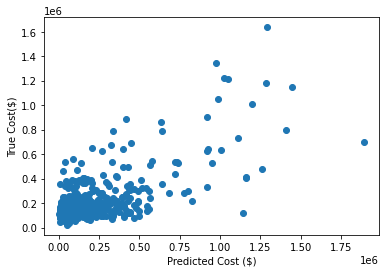

In [66]:
y_test_pred = xgbmodel2.predict(X_test)
plt.scatter(y_test,y_test_pred)
plt.xlabel('Predicted Cost ($)')
plt.ylabel('True Cost($)')

## 3 How Price is Predicted

The model that predicted the best "Price" was XGboost. I first cleaned the numeric and categorical data, then imputed missing values using KNN imputer. Afterwards, I used PCA, StandardScalar, and XGBoost in a pipeline to predict the results. 